In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder

from quantbullet.linear_product_model import (
    LinearProductRegressorBCD,
    LinearProductModelToolkit,
)
from quantbullet.preprocessing import FlatRampTransformer
from quantbullet.linear_product_model.datacontainer import ProductModelDataContainer
from quantbullet.linear_product_model.base import InteractionCoef
from quantbullet.model.feature import DataType, Feature, FeatureRole, FeatureSpec

In [2]:
def generate_interaction_data(n_samples=50_000, seed=42):
    """Generate synthetic multiplicative data: y = C * f(x1 | x2) * g(x3) + noise.

    x2 is categorical with two levels: 'A' (30%) and 'B' (70%).
    Category A follows a U-shape in x1; category B follows a linear trend.

    Returns (df, weights) where weights are random positive per-observation weights.
    """
    np.random.seed(seed)

    x2 = np.random.choice(['A', 'B'], size=n_samples, p=[0.3, 0.7])
    x1 = np.where(
        x2 == 'A',
        3 * np.random.randn(n_samples),
        3 * np.random.randn(n_samples)
    )

    f_x1 = np.where(
        x2 == 'A',
        x1**2,
        x1**2,
    )

    y = np.where(
        x2 == 'A',
        1.0 * f_x1 + np.random.randn(n_samples) * 5.0 + 1,
        5.0 * f_x1 + np.random.randn(n_samples) * 5.0 + 5
    )

    weights = np.random.exponential(scale=1.0, size=n_samples)
    # weights = np.ones(n_samples)

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
    df['x2'] = df['x2'].astype('category')
    return df, weights


df, weights = generate_interaction_data()
df.head()

,x1,x2,y
0,-0.264947,B,12.829545
1,4.510815,B,107.253908
2,-4.830043,B,122.957828
3,0.584786,B,14.116793
4,5.361340,A,38.073041


In [3]:
preprocess_config = {
    'x1': FlatRampTransformer(
        knots=list([ -5, 0, 5 ]),
        include_bias=True,
    ),
    'x2': OneHotEncoder(),
}

feature_spec = FeatureSpec(features=[
    Feature(name='x1', dtype=DataType.FLOAT, role=FeatureRole.MODEL_INPUT),
    Feature(name='x2', dtype=DataType.CATEGORY, role=FeatureRole.MODEL_INPUT),
    Feature(name='y', dtype=DataType.FLOAT, role=FeatureRole.TARGET),
])

tk = LinearProductModelToolkit(
    feature_spec=feature_spec,
    preprocess_config=preprocess_config,
).fit(df)
expanded_df = tk.get_expanded_df(df)

dcontainer = ProductModelDataContainer(
    df, expanded_df, response=df['y'], feature_groups=tk.feature_groups,
)

In [17]:
model = LinearProductRegressorBCD()
model.fit(
    dcontainer,
    feature_groups=tk.feature_groups,
    interactions={'x1': 'x2'},
    n_iterations=10,
    early_stopping_rounds=10,
    ftol=1e-10,
    weights=weights,
)

Iteration 1/10, Loss: 8.555352e+01
Iteration 2/10, Loss: 8.555352e+01
Iteration 3/10, Loss: 8.555352e+01
Iteration 4/10, Loss: 8.555352e+01
Iteration 5/10, Loss: 8.555352e+01
Iteration 6/10, Loss: 8.555352e+01
Converged at iteration 6: relative improvement over last 5 iterations = 0.00e+00 < ftol=1.0e-10 (loss 8.555352e+01 -> 8.555352e+01).


In [18]:
# preds = model.predict(dcontainer)
# mse = np.mean((df['y'].values - preds) ** 2)
# print(f"MSE: {mse:.4f}")

# interaction_coef = model.coef_['x1']
# print(f"\nx1 coef type: {type(interaction_coef).__name__}, by: {interaction_coef.by}")
# print(f"x1 categories: {set(interaction_coef.categories.keys())}")
# for cat_val, scalar in interaction_coef.scalars.items():
#     print(f"  A/E scalar for '{cat_val}': {scalar:.4f}")

# print(f"\nx3 coef type: {type(model.coef_['x3']).__name__}")
# print(f"\nloss_history length: {len(model.loss_history_)}")
# print(f"interaction_params_history length: {len(model.interaction_params_history_)}")

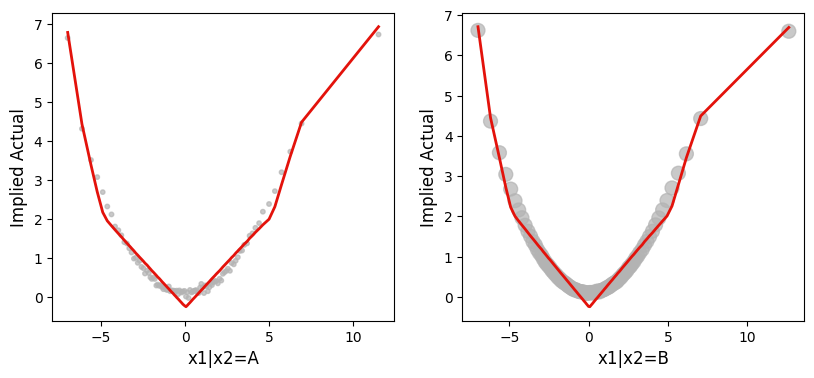

In [19]:
fig, axes = tk.plot_implied_actuals(model, dcontainer, sample_weights=weights, min_size=10, max_size=100)

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='x2', ylabel='Implied Actual'>, <Axes: >, <Axes: >],
       dtype=object))

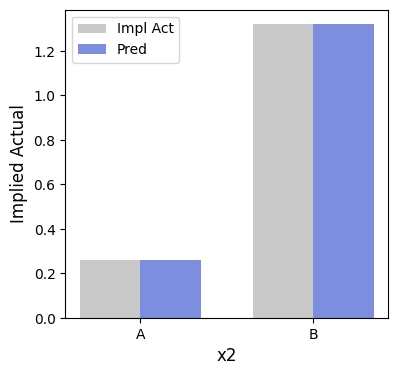

In [20]:
tk.plot_categorical_plots(model, dcontainer, sample_weights=weights)

In [21]:
model.block_means_

{'x1': np.float64(1.0000000000000004), 'x2': np.float64(0.9999999999999999)}

In [22]:
model.global_scalar_

np.float64(37.84604668812234)

(<Figure size 1400x900 with 4 Axes>,
 array([[<Axes: title={'center': 'Loss History'}, xlabel='Iteration', ylabel='MSE Loss'>,
         <Axes: title={'center': 'Loss Change per Iteration'}, xlabel='Iteration', ylabel='|ΔLoss|'>],
        [<Axes: title={'center': 'Global Scalar (end of iteration)'}, xlabel='Iteration', ylabel='Global Scalar'>,
         <Axes: title={'center': 'Global Scalar (per-group step trace)'}, xlabel='Step', ylabel='Global Scalar'>]],
       dtype=object))

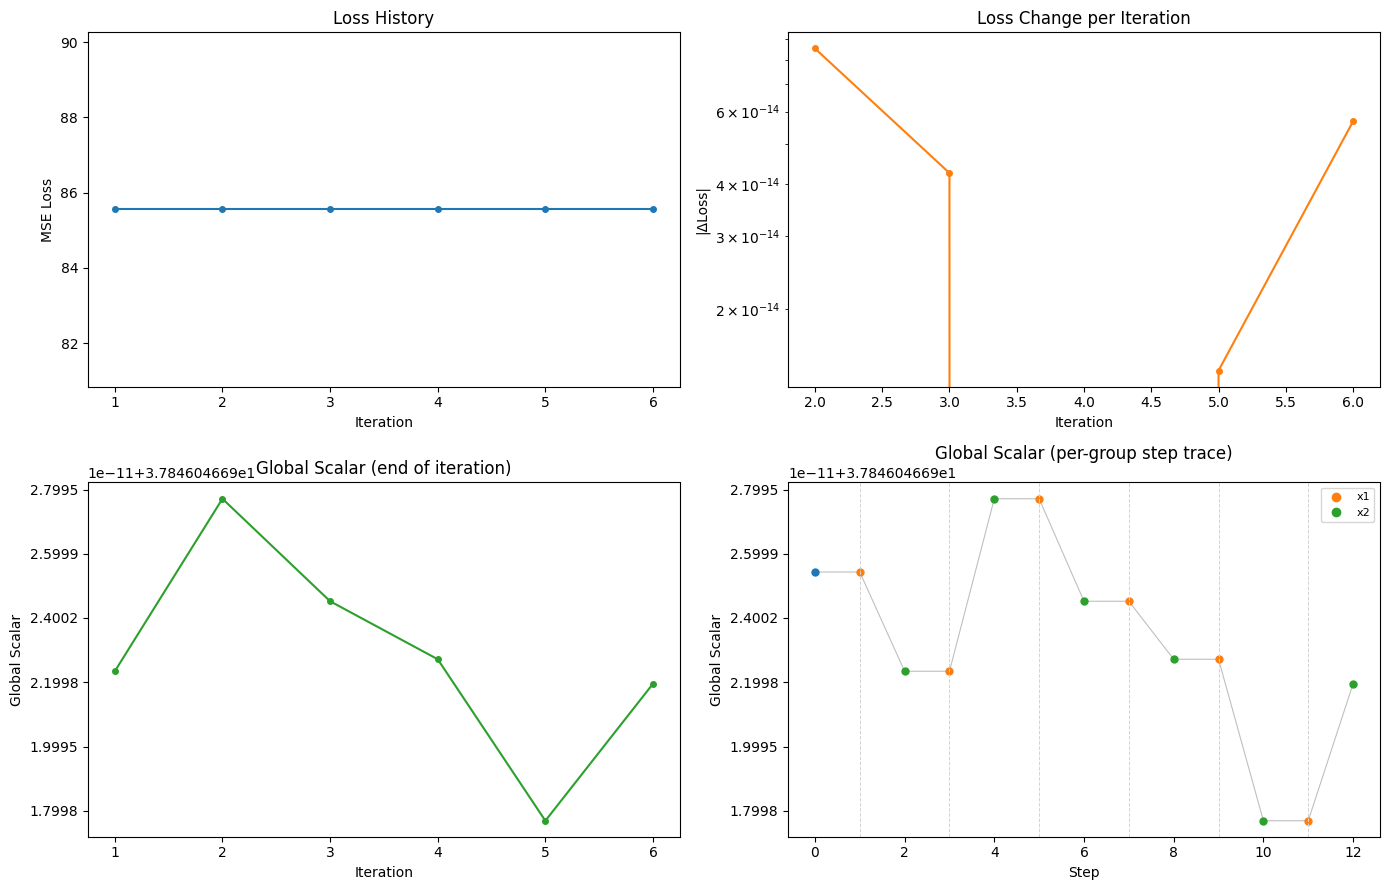

In [23]:
tk.plot_convergence_diagnostics(model)